In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages
import os
import pickle
from tensorly.decomposition import non_negative_parafac

import tensorflow as tf
cpu_devices = tf.config.list_physical_devices("CPU")
tf.config.set_visible_devices(cpu_devices)

from KDEpy import FFTKDE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
from pydiffmap import diffusion_map

In [ ]:
trigger_time = pd.read_csv(f"/media/ubuntu/sda/neuropixels/output_dir/{session}/stimulus_table.csv")


In [ ]:
import os
import tqdm
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d

session_folder = os.listdir("/media/ubuntu/sda/neuropixels/output_dir")
activity_dict = {}  
num_bins = 20
for session in tqdm.tqdm(session_folder):
    if 'session_' not in session:
        continue
        
    trigger_time = pd.read_csv(f"/media/ubuntu/sda/neuropixels/output_dir/{session}/stimulus_table.csv")
    spike_inf = pd.read_csv(f"/media/ubuntu/sda/neuropixels/output_dir/{session}/spike_inf.csv", index_col=0)
    
    filtered_spikes = spike_inf['id'].value_counts()
    filtered_spikes = filtered_spikes[filtered_spikes > 30000].index
    spike_inf = spike_inf[spike_inf['id'].isin(filtered_spikes)]
    
    regions = spike_inf['region'].unique()
    
    neuron_mappings = {}
    for region in regions:
        region_neurons = spike_inf[spike_inf['region'] == region]['id'].unique()
        region_neurons = np.intersect1d(region_neurons, filtered_spikes)
        
        if len(region_neurons) == 0:
            continue
            
        neuron_id_to_idx = {id: idx for idx, id in enumerate(region_neurons)}
        neuron_mappings[region] = {
            'neurons': region_neurons,
            'id_to_idx': neuron_id_to_idx,
            'n_neurons': len(region_neurons)
        }
    
    if not neuron_mappings:
        continue
        
    spike_times = spike_inf['time'].values
    spike_ids = spike_inf['id'].values
    spike_regions = spike_inf['region'].values
    
    for region in neuron_mappings:
        if region not in activity_dict:
            activity_dict[region] = {}
        activity_dict[region][session] = {}
    
    for image in range(117):
        trigger_time_temp = trigger_time[trigger_time['frame'] == image]
        
        for trial_idx, (_, row) in enumerate(trigger_time_temp.iterrows()):
            start_time = row['start_time']
            end_time = row['stop_time']
            duration = end_time - start_time
            
            mask = (spike_times >= start_time) & (spike_times < end_time)
            trial_spike_times = spike_times[mask] - start_time
            trial_spike_ids = spike_ids[mask]
            trial_spike_regions = spike_regions[mask]
            
            for region, mapping in neuron_mappings.items():
                region_mask = np.isin(trial_spike_regions, [region])
                region_spike_times = trial_spike_times[region_mask]
                region_spike_ids = trial_spike_ids[region_mask]
                
                n_neurons = mapping['n_neurons']
                neuron_id_to_idx = mapping['id_to_idx']
                
                if len(region_spike_times) == 0:
                    activity_matrix = np.zeros((n_neurons, num_bins))
                    activity_dict[region][session][f'{image}_{trial_idx}'] = activity_matrix
                    continue
                
                neuron_indices = np.array([neuron_id_to_idx[id] for id in region_spike_ids])
                
                counts, _, _ = np.histogram2d(
                    neuron_indices, 
                    region_spike_times,
                    bins=[n_neurons, num_bins],
                    range=[[0, n_neurons], [0, duration]]
                )
                
                bin_width = duration / num_bins
                firing_rates = counts / bin_width
                
                smoothed_rates = gaussian_filter1d(
                    firing_rates, 
                    sigma=2, 
                    axis=1,  
                    mode='nearest'
                )
                
                activity_dict[region][session][f'{image}_{trial_idx}'] = smoothed_rates

In [4]:
cluster_inf_all.to_csv("/media/ubuntu/sda/neuropixels/natural_image/cluster_inf_all.csv")

In [5]:
with open("/media/ubuntu/sda/neuropixels/natural_image/activity_dict_all_30000.pkl", 'wb') as f:
    pickle.dump(activity_dict, f)

In [3]:
with open("/media/ubuntu/sda/neuropixels/natural_image/activity_dict_all_30000.pkl", 'rb') as f:
    activity_dict = pickle.load(f)

In [4]:
cluster_inf_all = pd.read_csv("/media/ubuntu/sda/neuropixels/natural_image/cluster_inf_all.csv", index_col=0)

In [5]:
def getResponseCurve(train_dict, total_trial_len, bw=None, samp_interval=1, MINBW=10, MAXBW=50):
    """Computes smooth trial-averaged response to a stim in all directions from spike trains
    using a kernel density estimator, with per-trial KDE averaging."""

    ts = np.arange(0, total_trial_len + samp_interval, samp_interval)
    x_ts = 0.5 * (ts[:-1] + ts[1:])  # sample at the midpoints

    # Determine global bandwidth if not provided
    global_bw = bw
    if global_bw is None:
        # Find first non-empty trial to determine bandwidth
        for d in sorted(train_dict):
            for train in train_dict[d]:
                if train.size > 0:
                    temp_kde = FFTKDE(kernel='gaussian', bw=None).fit(train)
                    global_bw = temp_kde.bw
                    # Apply bandwidth constraints
                    global_bw = max(MINBW, min(global_bw, MAXBW))
                    break
            if global_bw is not None:
                break
        # If no spikes found in any trial, use default bandwidth
        if global_bw is None:
            global_bw = (MINBW + MAXBW) / 2

    all_ISJs = []
    
    for d in sorted(train_dict):
        trial_responses = []  # Store KDE results for each trial in this direction
        
        for train in train_dict[d]:
            if train.size == 0:
                # Handle empty trials with zero array
                y_trial = np.zeros_like(x_ts)
                trial_responses.append(y_trial)
                continue
                
            try:
                # Create KDE for this single trial
                ext_x_ts = np.r_[x_ts[0]-samp_interval, x_ts, x_ts[-1]+samp_interval]
                fftkde = FFTKDE(kernel='gaussian', bw=global_bw).fit(train)
                y_density = fftkde.evaluate(ext_x_ts)[1:-1]  # crop extended regions
                
                # Convert to firing rate (spikes/sec)
                y_trial = y_density * len(train) * 1000
                trial_responses.append(y_trial)
                
            except Exception as e:
                print(f'KDE failed for direction {d}, trial with {len(train)} spikes: {str(e)}')
                #trial_responses.append(np.zeros_like(x_ts))
        
        # Average all trials for this direction
        avg_response = np.mean(trial_responses, axis=0)
        all_ISJs.append(avg_response)
        
    return np.array(all_ISJs), x_ts

In [6]:
activity_dict_region = {}
filtered_neuron = {}
for region in ['VISp', 'VISal', 'VISam', 'VISrl', 'VISpm', 'VISl']:
    activity_dict_region[region] = {}
    cluster_inf_temp = cluster_inf_all[cluster_inf_all['ecephys_structure_acronym'] == region]
    filtered_neuron[region] = cluster_inf_temp['unit_id'].values

    for key, item in activity_dict.items():
        key = key.split("_")[0]
        if int(key) in filtered_neuron[region]:
            activity_dict_region[region][key] = item


In [16]:
activity_df = {}
for region in ['VISp', 'VISal', 'VISam', 'VISrl', 'VISpm', 'VISl']:
    activity_df[region] = []
    for neuron in activity_dict_region[region].keys():
        all_ISJs, x_ts = getResponseCurve(activity_dict_region[region][neuron], total_trial_len=251, bw=25, samp_interval=10)
        activity_df[region].append(all_ISJs)

    activity_df[region]  = np.stack(activity_df[region] , axis=2)
    activity_df[region]  = np.transpose(activity_df[region] , axes=(2, 1, 0))

KDE failed for direction 12, trial with 17 spikes: Every data point must be inside of the grid.
KDE failed for direction 12, trial with 12 spikes: Every data point must be inside of the grid.
KDE failed for direction 12, trial with 5 spikes: Every data point must be inside of the grid.
KDE failed for direction 12, trial with 4 spikes: Every data point must be inside of the grid.
KDE failed for direction 12, trial with 11 spikes: Every data point must be inside of the grid.
KDE failed for direction 12, trial with 4 spikes: Every data point must be inside of the grid.
KDE failed for direction 12, trial with 5 spikes: Every data point must be inside of the grid.
KDE failed for direction 107, trial with 23 spikes: Every data point must be inside of the grid.
KDE failed for direction 107, trial with 18 spikes: Every data point must be inside of the grid.
KDE failed for direction 93, trial with 9 spikes: Every data point must be inside of the grid.
KDE failed for direction 93, trial with 8 s

In [17]:
with open("/media/ubuntu/sda/neuropixels/natural_image/activity_region.pkl", 'wb') as f:
    pickle.dump(activity_df, f)

In [7]:
with open("/media/ubuntu/sda/neuropixels/natural_image/activity_region.pkl", 'rb') as f:
    activity_df = pickle.load(f)

In [8]:
stimulus_df = pd.DataFrame(activity_dict_region['VISal']['915964501'].keys(), columns=['id'])


In [9]:
for key, array in activity_df.items():
    if array.shape[2] != len(stimulus_df):
        raise ValueError(f"维度不匹配: {key}")
    
    transposed = np.transpose(array, (2, 0, 1))
    
    stimulus_df[key] = list(transposed)

In [ ]:


with PdfPages("/media/ubuntu/sda/neuropixels/natural_image/response_heatmap.pdf") as pdf:
    for i in range(len(stimulus_df)):
        response_matrix = stimulus_df['VISp'].values[i].astype(np.float32)
        neuron_means = np.mean(response_matrix, axis=1, keepdims=True)
        neuron_stds = np.std(response_matrix, axis=1, keepdims=True)
        response_matrix_z = (response_matrix - neuron_means) / (neuron_stds + 1e-8)

        n_components = 15  
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        svd_components = svd.fit_transform(response_matrix_z)

        explained_variance = svd.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)


        n_effective = np.argmax(cumulative_variance >= 0.95) + 1

        dm = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 3, epsilon = 1.0, alpha = 0.5, k=32)
        diffusion_coordinates = dm.fit_transform(svd_components)

        neuron_inf = pd.DataFrame(filtered_neuron['VISp'], columns=['id'])
        neuron_inf = pd.concat((neuron_inf, pd.DataFrame(diffusion_coordinates)), axis=1)
        neuron_inf['activity'] = list(response_matrix_z)

        fig, axes = plt.subplots(1, 3, figsize = (8, 6))
        axes = axes.flatten()
        for order in [0, 1, 2]:
            ax = axes[order]
            neuron_inf = neuron_inf.sort_values(by=order)
            sns.heatmap(np.stack(neuron_inf['activity'].values), cmap='coolwarm', ax=ax, cbar=False)
            
        fig.suptitle(stimulus_df['id'].values[i])
        pdf.savefig()
        plt.close()

In [10]:
activity = np.stack(stimulus_df['VISp'].values, axis=2)

In [30]:
from matplotlib.backends.backend_pdf import PdfPages

pdf_filename = "/media/ubuntu/sda/neuropixels/natural_image/diffusion_maps_per_neuron.pdf"
with PdfPages(pdf_filename) as pdf:
    for n in range(activity.shape[0]):
        response_matrix = activity[n, :, :].T
        neuron_means = np.mean(response_matrix, axis=1, keepdims=True)
        neuron_stds = np.std(response_matrix, axis=1, keepdims=True)
        response_matrix_z = (response_matrix - neuron_means) / (neuron_stds + 1e-8)
        
        n_components = 15  
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        svd_components = svd.fit_transform(response_matrix_z)
        
        dm = diffusion_map.DiffusionMap.from_sklearn(n_evecs=3, epsilon=1.0, alpha=0.5, k=32)
        diffusion_coordinates = dm.fit_transform(svd_components)
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        scatter = ax.scatter(
            diffusion_coordinates[:, 0],
            diffusion_coordinates[:, 1],
            diffusion_coordinates[:, 2],
            s=20
        )
        
        ax.set_title(f'Diffusion Map - Neruron {n})', fontsize=14)
        ax.set_xlabel('Diffusion Axis 1', fontsize=12)
        ax.set_ylabel('Diffusion Axis 2', fontsize=12)
        ax.set_zlabel('Diffusion Axis 3', fontsize=12)
        
        plt.tight_layout()
        
        pdf.savefig(fig)
        plt.close(fig)

print(f"PDF文件已保存至: {pdf_filename}")

PDF文件已保存至: /media/ubuntu/sda/neuropixels/natural_image/diffusion_maps_per_neuron.pdf


In [33]:
pdf_filename = "/media/ubuntu/sda/neuropixels/natural_image/diffusion_maps_per_stimuli.pdf"
with PdfPages(pdf_filename) as pdf:
    for n in range(activity.shape[2]):
        response_matrix = activity[:, :, n]
        neuron_means = np.mean(response_matrix, axis=1, keepdims=True)
        neuron_stds = np.std(response_matrix, axis=1, keepdims=True)
        response_matrix_z = (response_matrix - neuron_means) / (neuron_stds + 1e-8)
        
        n_components = 15  
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        svd_components = svd.fit_transform(response_matrix_z)
        
        dm = diffusion_map.DiffusionMap.from_sklearn(n_evecs=3, epsilon=1.0, alpha=0.5, k=32)
        diffusion_coordinates = dm.fit_transform(svd_components)
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        scatter = ax.scatter(
            diffusion_coordinates[:, 0],
            diffusion_coordinates[:, 1],
            diffusion_coordinates[:, 2],
            s=20
        )
        
        ax.set_title(f'Diffusion Map - Neruron {n})', fontsize=14)
        ax.set_xlabel('Diffusion Axis 1', fontsize=12)
        ax.set_ylabel('Diffusion Axis 2', fontsize=12)
        ax.set_zlabel('Diffusion Axis 3', fontsize=12)
        
        plt.tight_layout()
        
        pdf.savefig(fig)
        plt.close(fig)

print(f"PDF文件已保存至: {pdf_filename}")

PDF文件已保存至: /media/ubuntu/sda/neuropixels/natural_image/diffusion_maps_per_stimuli.pdf


In [45]:
import gudhi as gd

pdf_filename = "persistent_homology_per_stimuli.pdf"
with PdfPages(pdf_filename) as pdf:
    for n in range(activity.shape[2]):
        print(f"处理条件 {n+1}/{activity.shape[0]}...")
        
        response_matrix = activity[:, :, n]
        neuron_means = np.mean(response_matrix, axis=1, keepdims=True)
        neuron_stds = np.std(response_matrix, axis=1, keepdims=True)
        response_matrix_z = (response_matrix - neuron_means) / (neuron_stds + 1e-8)
        
        n_components = 15
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        svd_components = svd.fit_transform(response_matrix_z)
        
        dm = diffusion_map.DiffusionMap.from_sklearn(n_evecs=3, epsilon=1.0, alpha=0.5, k=32)
        diffusion_coordinates = dm.fit_transform(svd_components)
        
        point_cloud = diffusion_coordinates[:, :3]
        
        rips_complex = gd.RipsComplex(points=point_cloud, max_edge_length=2.0)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        
        persistence = simplex_tree.persistence()
        
        fig = plt.figure(figsize=(16, 8))
        
        ax1 = fig.add_subplot(121, projection='3d')
        sc = ax1.scatter(
            point_cloud[:, 0], 
            point_cloud[:, 1], 
            point_cloud[:, 2],
            c=np.linspace(0, 1, len(point_cloud)),
            cmap='viridis',
            s=30,
            alpha=0.8
        )
        ax1.set_title(f'Diffusion Map - Condition {n}\n({len(point_cloud)} Neurons)', fontsize=14)
        ax1.set_xlabel('Axis 1', fontsize=10)
        ax1.set_ylabel('Axis 2', fontsize=10)
        ax1.set_zlabel('Axis 3', fontsize=10)
        ax1.set_xlim3d(-0.5, 0.5)
        ax1.set_ylim3d(-0.5, 0.5)
        ax1.set_zlim3d(-0.5, 0.5)
        fig.colorbar(sc, ax=ax1, shrink=0.6, label='Neuron Index')
        
        ax2 = fig.add_subplot(122)
        
        dim0_pairs = []
        dim1_pairs = []
        
        for interval in persistence:
            dim = interval[0]
            birth = interval[1][0]
            death = interval[1][1]
            
            if death == float('inf'):
                death = birth + 1.0  
                
            if dim == 0:
                dim0_pairs.append((birth, death))
            elif dim == 1:
                dim1_pairs.append((birth, death))
        
        for i, (birth, death) in enumerate(dim0_pairs):
            ax2.plot([birth, death], [i, i], 'b-', linewidth=2)
            
        for i, (birth, death) in enumerate(dim1_pairs, start=len(dim0_pairs)):
            ax2.plot([birth, death], [i, i], 'r-', linewidth=2)
        
        ax2.set_title(f'Persistent Homology Barcode\nCondition {n}', fontsize=14)
        ax2.set_xlabel('Filtration Value', fontsize=12)
        ax2.set_ylabel('Topological Feature', fontsize=12)
        
        ax2.plot([], [], 'b-', label='H0 (Components)')
        ax2.plot([], [], 'r-', label='H1 (Loops)')
        ax2.legend(loc='lower right')
        
        max_death = max([d for _, d in dim0_pairs + dim1_pairs if not np.isinf(d)] + [0])
        ax2.set_xlim(0, min(max_death * 1.1, 2.0))
        ax2.set_ylim(-1, len(dim0_pairs) + len(dim1_pairs) + 1)
        
        ax2.grid(True, linestyle='--', alpha=0.6)
        
        info_text = (
            f'Topological Features:\n'
            f'H0: {len(dim0_pairs)} components\n'
            f'H1: {len(dim1_pairs)} loops'
        )
        ax2.text(0.95, 0.95, info_text, 
                 transform=ax2.transAxes, 
                 verticalalignment='top', 
                 horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        
        pdf.savefig(fig)
        plt.close(fig)

print(f"分析完成！结果已保存至: {pdf_filename}")

处理条件 1/464...
处理条件 2/464...
处理条件 3/464...
处理条件 4/464...
处理条件 5/464...
处理条件 6/464...
处理条件 7/464...
处理条件 8/464...
处理条件 9/464...
处理条件 10/464...
处理条件 11/464...
处理条件 12/464...
处理条件 13/464...
处理条件 14/464...
处理条件 15/464...
处理条件 16/464...
处理条件 17/464...
处理条件 18/464...
处理条件 19/464...
处理条件 20/464...
处理条件 21/464...
处理条件 22/464...
处理条件 23/464...
处理条件 24/464...
处理条件 25/464...
处理条件 26/464...
处理条件 27/464...
处理条件 28/464...
处理条件 29/464...
处理条件 30/464...
处理条件 31/464...
处理条件 32/464...
处理条件 33/464...
处理条件 34/464...
处理条件 35/464...
处理条件 36/464...
处理条件 37/464...
处理条件 38/464...
处理条件 39/464...
处理条件 40/464...
处理条件 41/464...
处理条件 42/464...
处理条件 43/464...
处理条件 44/464...
处理条件 45/464...
处理条件 46/464...
处理条件 47/464...
处理条件 48/464...
处理条件 49/464...
处理条件 50/464...
处理条件 51/464...
处理条件 52/464...
处理条件 53/464...
处理条件 54/464...
处理条件 55/464...
处理条件 56/464...
处理条件 57/464...
处理条件 58/464...
处理条件 59/464...
处理条件 60/464...
处理条件 61/464...
处理条件 62/464...
处理条件 63/464...
处理条件 64/464...
处理条件 65/464...
处理条件 66/464...
处理条件 67/464...
处理条件

In [440]:
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import networkx as nx

In [497]:
response_matrix = activity[:, :, 2]
neuron_means = np.mean(response_matrix, axis=1, keepdims=True)
neuron_stds = np.std(response_matrix, axis=1, keepdims=True)
response_matrix_z = (response_matrix - neuron_means) / (neuron_stds + 1e-8)

mean = np.mean(activity[:, :, 0])
std = np.std(activity[:, :, 0])
random_matrix = np.random.randn(464, 26) * std + mean

n_components = 15
pca = PCA(n_components=n_components, random_state=42)
pca_components = svd.fit_transform(random_matrix)

adjacency_matrix = kneighbors_graph(
            pca_components, n_neighbors=10, mode='distance', include_self=False
        ).toarray()

In [ ]:
adjacency_matrix

In [498]:
G = nx.Graph()
    
for i in range(pca_components.shape[0]):
    G.add_node(i, pos=pca_components[i])

for i in range(adjacency_matrix.shape[0]):
    for j in range(i+1, adjacency_matrix.shape[1]):
        if adjacency_matrix[i, j] > 0:
            weight = adjacency_matrix[i, j]
            G.add_edge(i, j, weight=weight)

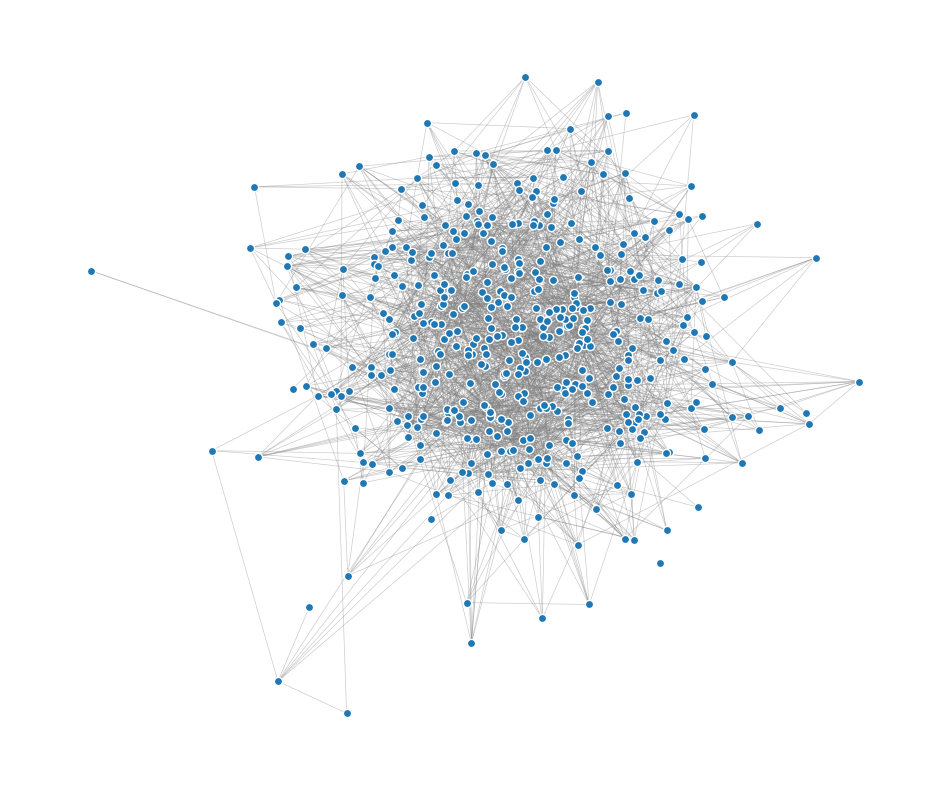

In [499]:
plt.figure(figsize=(12, 10))
for i in range(pca_components.shape[0]):
    G.nodes[i]['pos'] = pca_components[i, :2] 

pos = nx.get_node_attributes(G, 'pos')

nodes = nx.draw_networkx_nodes(
    G, pos, node_size=35, alpha=1, edgecolors='white'
)

edges = nx.draw_networkx_edges(
    G, pos, width=0.5, edge_color='gray', alpha=0.4
)

plt.axis('off')


#plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

class DiffusionReconstructor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DiffusionReconstructor, self).__init__()
        layers = []
        prev_dim = input_dim
        hidden_dims = [5, 8, 12]

        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_dim = h_dim

        self.decoder = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        x = self.decoder(x)
        return self.output_layer(x)
    
class CustomDataset(Dataset):
    def __init__(self, data, reconstructed_data):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(reconstructed_data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [202]:
dataset = CustomDataset(point_cloud, response_matrix_z)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 30 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [203]:
model = DiffusionReconstructor(
    input_dim=3,
    output_dim=26)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

Using device: cuda


In [204]:
model.train()
best_val_loss = float('inf')

for epoch in range(100):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    print(f'Train loss: {train_loss}')
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(test_loader.dataset)

        print(f"Test loss: {val_loss}")


Train loss: 1.22194719089652
Test loss: 1.0258018778216453
Train loss: 1.1140317155344468
Test loss: 0.9861995000993052
Train loss: 1.0285468079009146
Test loss: 0.9358928261264678
Train loss: 0.9689392461930967
Test loss: 0.8780760668939159
Train loss: 0.9139453336556325
Test loss: 0.8221409340058604
Train loss: 0.8590981137720402
Test loss: 0.7762083622717089
Train loss: 0.7994604774241177
Test loss: 0.7335336092979677
Train loss: 0.7549559220149511
Test loss: 0.6834455478575922
Train loss: 0.7101752677696413
Test loss: 0.6417784479356581
Train loss: 0.6756990770445358
Test loss: 0.5963509986477513
Train loss: 0.6485397132901811
Test loss: 0.5567024792394331
Train loss: 0.6051783968174875
Test loss: 0.5266135892560405
Train loss: 0.5836229872189442
Test loss: 0.49490242619668284
Train loss: 0.559412497073171
Test loss: 0.4609478365990423
Train loss: 0.5260516838886025
Test loss: 0.4318487528831728
Train loss: 0.5122846578652004
Test loss: 0.4223314206446371
Train loss: 0.488210624761

In [205]:
n_points = 100
x_coords = np.linspace(-2, 2, n_points)
z_coords = np.zeros_like(x_coords)
y_coords = np.zeros_like(x_coords)

coord_matrix = np.column_stack((x_coords, y_coords, z_coords))

model.eval()
reconstructed_matrix = model(torch.tensor(coord_matrix, dtype=torch.float32).to(device))

In [206]:
points = np.random.uniform(-1, 1, (1000, 3))

points = points[np.linalg.norm(points, axis=1) <= 1]

while len(points) < 1000:
    new_points = np.random.uniform(-1, 1, (1000, 3))
    new_points = new_points[np.linalg.norm(new_points, axis=1) <= 1]
    points = np.vstack((points, new_points))

points = points[:1000]  

model.eval()
reconstructed_matrix = model(torch.tensor(points, dtype=torch.float32).to(device)).cpu().detach().numpy()
max_index = np.argmax(reconstructed_matrix, axis=1) / 26
double_ridge = []
for row in range(len(reconstructed_matrix)):
    max_id_list = []
    for i in range(1, len(reconstructed_matrix[row, :]) - 1):
        if (reconstructed_matrix[row, i-1] < reconstructed_matrix[row, i]) & (reconstructed_matrix[row, i + 1] < reconstructed_matrix[row, i]) & (reconstructed_matrix[row, i] > 0):
            max_id_list.append(i)
    double_ridge.append(len(max_id_list))

double_ridge = np.array(double_ridge)

max_value = np.max(reconstructed_matrix, axis=1)

In [207]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color = np.array(max_index)
    ),
    name='Neurons'
))

fig.update_layout(
    title='3D Neuron Distribution (Gray: score<0.5)',
    scene=dict(
        xaxis_title='Diffusion Axis 1',
        yaxis_title='Diffusion Axis 2',
        zaxis_title='Diffusion Axis 3',
        camera=dict(eye=dict(x=1.5, y=1, z=0.1))
    ),
    width=800,
    height=600
)

fig.show()

In [293]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        layers = []
        prev_dim = input_dim
        hidden_dims = [24, 16, 12, 6, 3]

        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_dim = h_dim

        self.encoder = nn.Sequential(*layers)

        self.bottleneck = nn.Linear(3, 3)

        layers = []
        prev_dim = 3

        for h_dim in [6, 12, 16, 24, 26]:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_dim = h_dim

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        bottleneck = self.bottleneck(x)
        return self.decoder(bottleneck)

In [294]:
class Autoencoder_Dataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [405]:
activity.shape

(464, 26, 118)

In [427]:
neuron_means = np.mean(activity, axis=2, keepdims=True)
neuron_stds = np.std(activity, axis=2, keepdims=True)
response_matrix_z = (activity - neuron_means) / (neuron_stds + 1e-8)
response_matrix_z = activity
response_matrix_z = response_matrix_z.transpose(0, 2, 1)
response_matrix_z = np.reshape(response_matrix_z, (response_matrix_z.shape[0] * response_matrix_z.shape[1], response_matrix_z.shape[2]))
#ref_matrix = np.zeros((464, 26))

#response_matrix_z = np.vstack((response_matrix_z, ref_matrix))

In [428]:
n_components = 15
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd_components = svd.fit_transform(response_matrix_z)

import umap
umap = UMAP(n_components=3)
umap_coordinates = umap.fit_transform(svd_components)

In [429]:
umap_coordinates_reshape = np.reshape(umap_coordinates, (activity.shape[0], 118, 3))

In [421]:
neuron_inf = pd.DataFrame(response_matrix_z)
neuron_inf = pd.concat((neuron_inf, pd.DataFrame(umap_coordinates, columns = ['0', '1', '2'])), axis=1)
neuron_inf = neuron_inf.sort_values(by = '2')